# Final Project

## Setup

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tqdm import tqdm

from IPython import display

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except RuntimeError as e:
        print(e)

2023-12-08 15:56:23.843412: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 15:56:23.867222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 15:56:25.088245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-08 15:56:28.139880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

In [2]:
train_GAN = False
train_original_classifier = False
train_GAN_classifier = True

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = tf.image.resize(train_images, [64, 64])
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
# train_images = (train_images - 0.5) / 0.5

2023-12-08 15:56:28.661412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 15:56:28.661528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 15:56:28.661569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
noise_dim = 100

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## DCGAN Network

In [7]:
def make_generator_model(image_widthheight):
    initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.02)
    batch_initializer = tf.keras.initializers.RandomNormal(mean=1, stddev=0.02)
    zeror = tf.keras.initializers.Zeros()
    model = tf.keras.Sequential()
    # model.add(layers.Dense(image_widthheight//8*image_widthheight//8*image_widthheight*4, use_bias=False, input_shape=(100,)))
    # model.add(layers.BatchNormalization())
    # model.add(layers.ReLU())

    # model.add(layers.Reshape((image_widthheight//8, image_widthheight//8, image_widthheight*4)))
    # assert model.output_shape == (None, image_widthheight//8, image_widthheight//8, image_widthheight*4)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(image_widthheight*8, (4, 4), strides=(1, 1), use_bias=False, input_shape=(1,1,100), kernel_initializer=initializer))
    # assert model.output_shape == (None, image_widthheight//8, image_widthheight//8, image_widthheight*4)
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(image_widthheight*4, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    # assert model.output_shape == (None, image_widthheight//4, image_widthheight//4, image_widthheight*2)
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(image_widthheight*2, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    # assert model.output_shape == (None, image_widthheight//4, image_widthheight//4, image_widthheight*2)
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(image_widthheight, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    # assert model.output_shape == (None, image_widthheight//2, image_widthheight//2, image_widthheight)
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer, activation='tanh'))
    # assert model.output_shape == (None, image_widthheight, image_widthheight, 3)

    return model

In [8]:
def make_discriminator_model(image_widthheight):
    initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.02)
    batch_initializer = tf.keras.initializers.RandomNormal(mean=1, stddev=0.02)
    zeror = tf.keras.initializers.Zeros()
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(image_widthheight, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer,
                                     input_shape=[image_widthheight, image_widthheight, 3]))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(image_widthheight*2, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer))
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(image_widthheight*4, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer))
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(image_widthheight*8, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer))
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(1, (4, 4), strides=(2, 2), kernel_initializer=initializer, activation="sigmoid"))

    return model

In [9]:
generator = make_generator_model(64)

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097152   
 Transpose)                                                      
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 256)         1024      
 chNormalization)                                       

/home/cbeam18/.local/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [10]:
discriminator = make_discriminator_model(64)

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_4 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                      

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

In [12]:
import matplotlib.pyplot as plt
from IPython import display

seed = tf.random.normal([49, 1, 1, noise_dim])

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(7, 7))

  for i in range(49):
      plt.subplot(7, 7, i+1)
      plt.imshow((predictions[i] + 1) / 2)
      plt.axis('off')

  plt.savefig('outputs/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  plt.close()

In [13]:
@tf.function
def train_step(images):
    noises = tf.random.normal([BATCH_SIZE, 1, 1, noise_dim])
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noises, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noises, training=True)
        fake_output = discriminator(generated_images, training=True)
        g_loss = generator_loss(fake_output)
        gen_loss = g_loss

    grad_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    resize_layer = tf.keras.layers.Resizing(64, 64)
    for epoch in tqdm(range(epochs)):
        # start = time.time()
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
            # train_step(resize_layer(batch))

        print(f"Epoch {epoch+1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")
        generate_and_save_images(generator, epoch, seed)
        # print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [14]:
if train_GAN:
  train(train_dataset, 150)

In [15]:
if train_GAN:
  generator.save_weights("models/generator_64.ckpt")
  discriminator.save_weights("models/discriminator_64.ckpt")
else:
  generator.load_weights("models/generator_64.ckpt")
  discriminator.load_weights("models/discriminator_64.ckpt")

## MobileNet V2 - No GAN inputs

In [16]:
keras.backend.clear_session()
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = tf.image.resize(train_images, (64, 64))

In [17]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomFlip("vertical"),
        keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1)
    ]
)

In [18]:
base_mobile_model = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128,128,3),
    include_top=False
)

base_mobile_model.trainable = False

inputs = keras.Input(shape=(64,64,3))
x = data_augmentation(inputs)

scaled_layer = keras.layers.Rescaling(scale=1/255.0)
resize_layer = tf.keras.layers.Resizing(128, 128)
x = resize_layer(scaled_layer(x))

x = base_mobile_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(10)(x)
mobile_model = keras.Model(inputs, outputs)

mobile_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [19]:
if train_original_classifier:
  keras.backend.clear_session()
  mobile_model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'],
  )

  logdir = os.path.join("logs", "original_classifier_64")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  epochs = 20
  mobile_model.fit(train_images, train_labels, batch_size=128, epochs=epochs, callbacks=[tensorboard_callback])

In [20]:
if train_original_classifier:
  keras.backend.clear_session()
  base_mobile_model.trainable = True

  mobile_model.compile(
      optimizer=keras.optimizers.Adam(1e-5),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'],
  )

  mobile_model.fit(train_images, train_labels, batch_size=128, epochs=10) #, callbacks=[tensorboard_callback])

In [21]:
if train_original_classifier:
  mobile_model.save_weights("models/mobile_model_64.ckpt")
else:
  mobile_model.load_weights("models/mobile_model_64.ckpt")

## SRGAN

In [22]:
def GENBlock(x):
    out = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.PReLU()(out)
    out = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Add()([out, x])
    return out

def DISBlock(x, n):
    out = keras.layers.Conv2D(n, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.LeakyReLU(0.2)(out)
    out = keras.layers.Conv2D(n, (3,3), (2,2), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.LeakyReLU(0.2)(out)
    return out

In [23]:
inputs = keras.Input(shape=(64,64,3))
scaled_layer = keras.layers.Rescaling(scale=1/255.0, offset=0)

# x = scaled_layer(inputs)
x = keras.layers.Conv2D(64, (9,9), (1,1), padding='same')(inputs)
x = keras.layers.PReLU()(x)
x_skip = x
for i in range(5):
    x = GENBlock(x)
x = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Add()([x, x_skip])

x = keras.layers.Conv2D(256, (3,3), (1,1), padding='same')(x)
x = keras.layers.Reshape((x.shape[1]*2, x.shape[2]*2, x.shape[3]//4))(x)
x = keras.layers.PReLU()(x)

x = keras.layers.Conv2D(256, (3,3), (2,2), padding='same')(x)
x = keras.layers.Reshape((x.shape[1]*2, x.shape[2]*2, x.shape[3]//4))(x)
x = keras.layers.PReLU()(x)

outputs = keras.layers.Conv2D(3, (9,9), (1,1), padding='same')(x)

srgenerator_model = keras.Model(inputs, outputs)
srgenerator_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           15616     ['input_3[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 64, 64, 64)           262144    ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 64, 64, 64)           36928     ['p_re_lu[0][0]']             
                                                                                            

In [24]:
srgenerator_model.load_weights("models/gen_model.ckpt")

## Training New Model

In [77]:
base_mobile_modelB = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128,128,3),
    include_top=False
)

base_mobile_modelB.trainable = False

inputs = keras.Input(shape=(128,128,3))
x = data_augmentation(inputs)

scaled_layer = keras.layers.Rescaling(scale=1/255.0)
resize_layer = tf.keras.layers.Resizing(128, 128)
x = resize_layer(x)

x = base_mobile_modelB(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(10)(x)
modelB = keras.Model(inputs, outputs)

modelB.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [69]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

In [70]:
class_length = 5000
percent_cut = 0.5
subset_length = int(percent_cut*class_length)

In [71]:
subset_indicies = np.concatenate([np.arange(x * class_length, x * class_length + subset_length) for x in np.arange(0,10)])

In [72]:
train_images = train_images[np.isin(np.argsort(train_labels.flatten()), subset_indicies).flatten()]
train_labels = train_labels[np.isin(np.argsort(train_labels.flatten()), subset_indicies).flatten()]

In [73]:
train_images = tf.image.resize(train_images, (128, 128))

In [52]:
custom_ds = tf.keras.utils.image_dataset_from_directory("fake_dataset2", labels="inferred", batch_size=128, image_size=(64, 64), shuffle=False)
custom_ds_SRGAN = custom_ds.map(lambda x, y: (tf.cast(tf.clip_by_value(srgenerator_model(scaled_layer(x), training=False), 0, 255), "uint8"), y))


Found 10000 files belonging to 10 classes.


In [53]:
custom_images = tf.convert_to_tensor(np.concatenate([x for x,y in custom_ds_SRGAN], axis=0))

In [54]:
custom_labels = (np.concatenate([y for x,y in custom_ds], axis=0))
custom_labels = custom_labels.astype(np.float32).astype(np.uint8)

In [74]:
train_images = tf.cast(train_images, "uint8")

In [75]:
train_images2 = tf.concat([train_images, custom_images], axis=0)
train_labels2 = np.concatenate([train_labels, np.vstack(custom_labels)], axis=0)

In [78]:
if train_GAN_classifier:
  keras.backend.clear_session()
  modelB.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'],
  )

  logdir = os.path.join("logs", "gan_classifier2_128")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  epochs = 20
  modelB.fit(train_images2, train_labels2, batch_size=128, epochs=epochs, callbacks=[tensorboard_callback])

Epoch 1/20
274/274 [==============================] - 7s 20ms/step - loss: 2.1259 - accuracy: 0.2313
Epoch 2/20
274/274 [==============================] - 6s 20ms/step - loss: 1.9306 - accuracy: 0.2965
Epoch 3/20
274/274 [==============================] - 6s 20ms/step - loss: 1.8921 - accuracy: 0.3098
Epoch 4/20
274/274 [==============================] - 6s 20ms/step - loss: 1.8631 - accuracy: 0.3205
Epoch 5/20
274/274 [==============================] - 6s 21ms/step - loss: 1.8542 - accuracy: 0.3292
Epoch 6/20
274/274 [==============================] - 6s 21ms/step - loss: 1.8464 - accuracy: 0.3283
Epoch 7/20
274/274 [==============================] - 6s 20ms/step - loss: 1.8393 - accuracy: 0.3335
Epoch 8/20
274/274 [==============================] - 6s 21ms/step - loss: 1.8329 - accuracy: 0.3339
Epoch 9/20
274/274 [==============================] - 6s 20ms/step - loss: 1.8316 - accuracy: 0.3342
Epoch 10/20
274/274 [==============================] - 5s 20ms/step - loss: 1.8300 - accura

In [89]:
if train_GAN_classifier:
  keras.backend.clear_session()
  base_mobile_modelB.trainable = True

  modelB.compile(
      optimizer=keras.optimizers.Adam(1e-5),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'],
  )

  modelB.fit(train_images2, train_labels2, batch_size=128, epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
274/274 [==============================] - 21s 42ms/step - loss: 1.0331 - accuracy: 0.6272
Epoch 2/10
274/274 [==============================] - 12s 43ms/step - loss: 1.0248 - accuracy: 0.6289
Epoch 3/10
274/274 [==============================] - 12s 43ms/step - loss: 1.0227 - accuracy: 0.6298
Epoch 4/10
274/274 [==============================] - 12s 43ms/step - loss: 1.0070 - accuracy: 0.6364
Epoch 5/10
274/274 [==============================] - 12s 42ms/step - loss: 1.0026 - accuracy: 0.6409
Epoch 6/10
274/274 [==============================] - 12s 43ms/step - loss: 0.9939 - accuracy: 0.6412
Epoch 7/10
274/274 [==============================] - 12s 42ms/step - loss: 0.9794 - accuracy: 0.6449
Epoch 8/10
274/274 [==============================] - 12s 42ms/step - loss: 0.9789 - accuracy: 0.6490
Epoch 9/10
274/274 [==============================] - 12s 45ms/step - loss: 0.9722 - accuracy: 0.6496
Epoch 10/10
274/274 [==============================] - 12s 43ms/step - loss: 0.972

In [93]:
if train_GAN_classifier:
  modelB.save_weights("models/modelB2_128.ckpt")
else:
  modelB.load_weights("models/modelB2_128.ckpt")

## Compare Against Test Dataset

In [94]:
keras.backend.clear_session()
(_, _), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
test_images = tf.image.resize(test_images, (128, 128))

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

In [95]:
class_accuracy_original = keras.metrics.Accuracy()
class_accuracy_gan = keras.metrics.Accuracy()

true_stack = []
orig_stack = []
gan_stack = []
resize_layer = tf.keras.layers.Resizing(64, 64)
for batch in test_dataset:
    batch_size = len(batch[0])
    pred_orig = mobile_model(resize_layer(batch[0]), training=False)
    pred_gan = modelB(batch[0], training=False)

    label_orig = tf.reshape(tf.cast(tf.math.argmax(pred_orig, axis=1), dtype=tf.uint8), (batch_size, 1))
    label_gan = tf.reshape(tf.cast(tf.math.argmax(pred_gan, axis=1), dtype=tf.uint8), (batch_size, 1))

    class_accuracy_original.update_state(batch[1], label_orig)
    class_accuracy_gan.update_state(batch[1], label_gan)

    true_stack.append(batch[1])
    orig_stack.append(label_orig)
    gan_stack.append(label_gan)

print(f"Oringinal Accuracy: {class_accuracy_original.result().numpy()}, GAN Classifier Accuracy: {class_accuracy_gan.result().numpy()}")

Oringinal Accuracy: 0.8892999887466431, GAN Classifier Accuracy: 0.7020999789237976


In [96]:
tf.math.confusion_matrix(
    tf.unstack(tf.concat(true_stack, axis=0), axis=1)[0], 
    tf.unstack(tf.concat(orig_stack, axis=0), axis=1)[0], num_classes=10
)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[912,   6,   4,   4,   3,   0,   0,   4,  43,  24],
       [  3, 937,   0,   0,   0,   0,   0,   0,   3,  57],
       [ 27,   2, 870,  28,  34,   9,  12,  14,   3,   1],
       [  7,   7,  27, 795,  19,  99,  11,  18,   9,   8],
       [  2,   1,  26,  16, 874,  11,   8,  58,   3,   1],
       [  2,   0,  11,  95,  15, 842,   3,  25,   2,   5],
       [  7,   4,  18,  42,  24,  15, 875,   5,   6,   4],
       [ 14,   2,   7,  16,  35,  23,   2, 894,   2,   5],
       [ 27,  18,   1,   0,   1,   1,   1,   1, 936,  14],
       [  5,  31,   0,   0,   0,   0,   0,   1,   5, 958]], dtype=int32)>

In [97]:
tf.math.confusion_matrix(
    tf.unstack(tf.concat(true_stack, axis=0), axis=1)[0], 
    tf.unstack(tf.concat(gan_stack, axis=0), axis=1)[0], num_classes=10
)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[751,  24,  48,  23,  11,   7,   7,   5,  80,  44],
       [ 12, 885,   8,   3,   0,   5,  11,   0,  18,  58],
       [ 37,   6, 661,  75,  61,  52,  83,   8,  12,   5],
       [ 15,   6,  62, 558,  37, 162,  99,  20,  13,  28],
       [ 24,   2, 114,  76, 596,  20, 106,  41,   8,  13],
       [  4,   8,  47, 223,  26, 595,  58,  26,   5,   8],
       [  4,   8,  41,  51,  19,  16, 838,   6,   6,  11],
       [ 26,   3,  42, 108,  89,  95,  26, 573,   5,  33],
       [ 85,  54,  11,  22,   1,   9,   4,   3, 778,  33],
       [ 22, 102,   7,  29,   5,   6,  14,   4,  25, 786]], dtype=int32)>

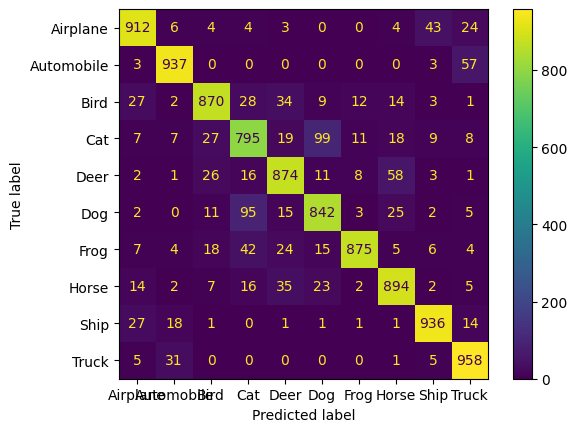

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

cm = confusion_matrix(
    y_true=tf.unstack(tf.concat(true_stack, axis=0), axis=1)[0].numpy(), 
    y_pred=tf.unstack(tf.concat(orig_stack, axis=0), axis=1)[0].numpy(), 
    labels=class_labels
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    display_labels=class_names)
disp.plot()
plt.show()
plt.close()

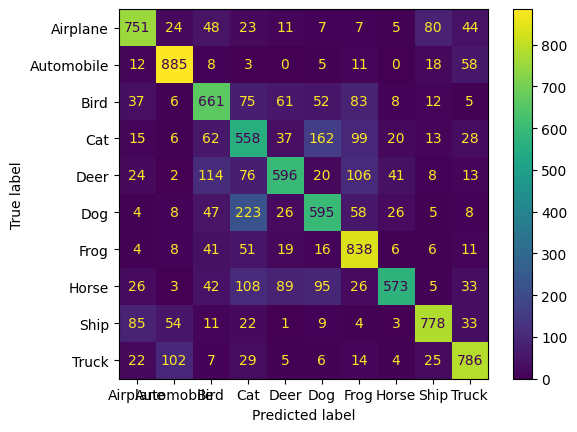

In [99]:
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

cm = confusion_matrix(
    y_true=tf.unstack(tf.concat(true_stack, axis=0), axis=1)[0].numpy(), 
    y_pred=tf.unstack(tf.concat(gan_stack, axis=0), axis=1)[0].numpy(), 
    labels=class_labels
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    display_labels=class_names)
disp.plot()
plt.show()
plt.close()